In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')
pd.options.display.max_columns = None

In [2]:
# Load Data
matched_flowlines_gdf = gpd.read_file('flowlines_pop_dems.geojson')

In [3]:
matched_flowlines_gdf.shape[0]

14922

In [4]:
# Initialize a counter for total number of line segments
total_line_segments = 0

# Iterate over each geometry in the dataset
for geom in matched_flowlines_gdf['geometry']:
    if isinstance(geom, MultiLineString):
        # Count each LineString in the MultiLineString
        total_line_segments += len(geom.geoms)
    elif isinstance(geom, LineString):
        # If it's a single LineString, count it as 1
        total_line_segments += 1

# Output the total number of line segments
print(f"Total number of individual line segments: {total_line_segments}")


Total number of individual line segments: 26361


### Print Global Linestring Min/Max of Multi-line strings

In [5]:
# Initialize variables to store global min and max lengths
global_min_length = float('inf')
global_max_length = float('-inf')

# Iterate over each geometry in the dataset
for geom in matched_flowlines_gdf['geometry']:
    # Check if the geometry is a MultiLineString
    if isinstance(geom, MultiLineString):
        # Iterate over each LineString in the MultiLineString using .geoms
        for line in geom.geoms:
            length = line.length  # Calculate the length of each LineString
            # Update global min and max lengths
            if length < global_min_length:
                global_min_length = length
            if length > global_max_length:
                global_max_length = length
    # If the geometry is a single LineString (not MultiLineString), handle it
    elif isinstance(geom, LineString):
        length = geom.length
        if length < global_min_length:
            global_min_length = length
        if length > global_max_length:
            global_max_length = length

# Print the global min and max lengths in meters
print(f"Global minimum length (in meters): {global_min_length}")
print(f"Global maximum length (in meters): {global_max_length}")

Global minimum length (in meters): 4.413513514328978e-08
Global maximum length (in meters): 0.21014232490190082


## Frequency Distribution of LineString Lengths

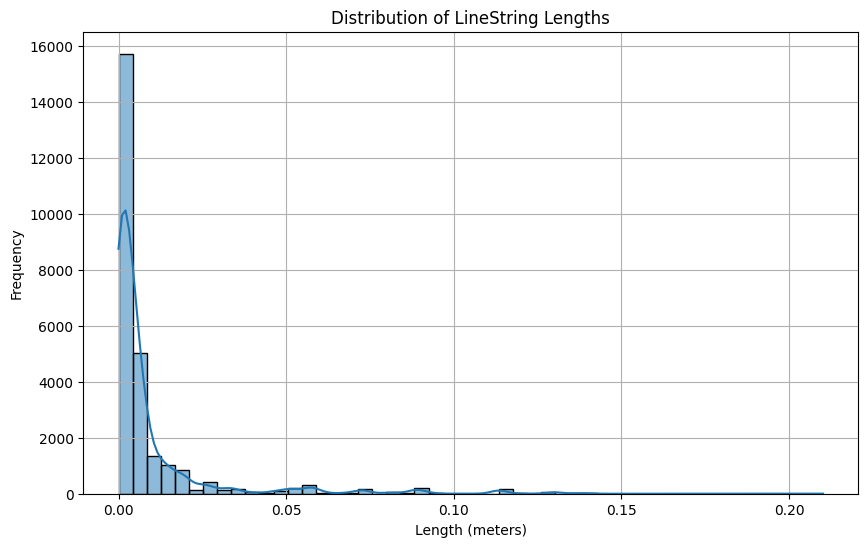

In [6]:
# Initialize a list to store the lengths in meters
line_lengths = []

# Iterate over each geometry in the dataset and calculate lengths
for geom in matched_flowlines_gdf['geometry']:
    if isinstance(geom, MultiLineString):
        # Iterate over each LineString in the MultiLineString
        for line in geom.geoms:
            line_lengths.append(line.length)  # Append the length of each LineString
    elif isinstance(geom, LineString):
        line_lengths.append(geom.length)  # Append the length of the LineString

# Visualize the distribution of lengths using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(line_lengths, bins=50, kde=True)  # kde=True adds a smoothed curve
plt.title('Distribution of LineString Lengths')
plt.xlabel('Length (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

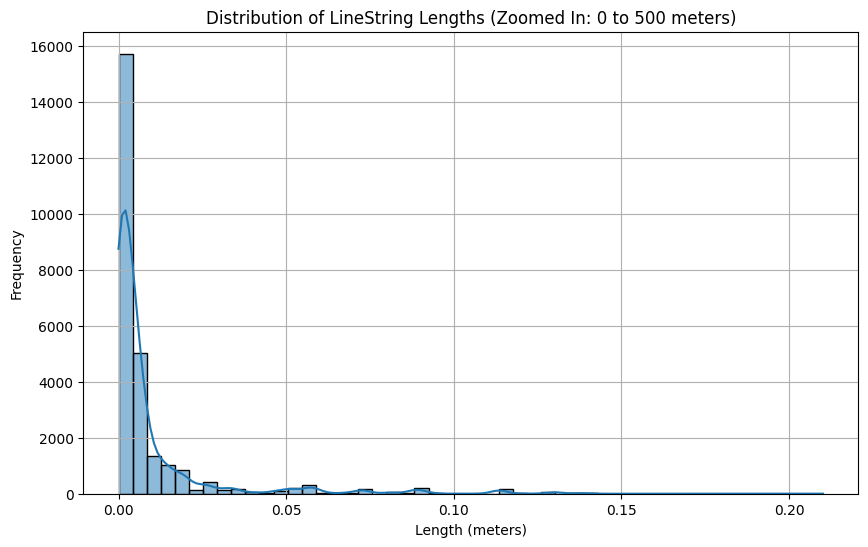

In [7]:
# Define a maximum length to zoom into (e.g., focus on lengths below 500 meters)
max_length_to_plot = 500  # You can adjust this to fit the part of the distribution you want to focus on

# Filter the lengths to include only those below the defined max length
filtered_lengths = [length for length in line_lengths if length <= max_length_to_plot]

# Plot the filtered lengths using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_lengths, bins=50, kde=True)  # Increase the number of bins for more detail
plt.title(f'Distribution of LineString Lengths (Zoomed In: 0 to {max_length_to_plot} meters)')
plt.xlabel('Length (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Split each multi-line string segments into 50 meter linestrings

I chose 50 meters as the uniform segment length based on the observed distribution of LineString lengths in the dataset, which is right-skewed, with a significant concentration of shorter lengths in the 0-100 meters range.

By selecting 50 meters, we achieve a balance between:

- Preserving detail for shorter lines: Many of the lines in the dataset are relatively short (as seen in the first bin of the distribution). Choosing 50 meters ensures that we don't excessively subdivide these already short geometries.
- Reasonable subdivision for longer lines: For longer LineString geometries, 50 meters allows for a uniform subdivision that still captures spatial variation without resulting in an overwhelming number of segments.

This length provides a good compromise between accuracy and performance, creating enough segments to maintain the structural integrity of the data while avoiding excessive fragmentation.

In [8]:
import pandas as pd
from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

# Function to split a LineString into uniform-length segments
def split_line(line, segment_length):
    segments = []
    num_segments = int(line.length // segment_length)  # Calculate how many full segments can be made
    # Add full-length segments
    for i in range(num_segments):
        start = line.interpolate(i * segment_length)
        end = line.interpolate((i + 1) * segment_length)
        segments.append(LineString([start, end]))
    # Add the remaining part of the line (if any)
    if line.length % segment_length != 0:
        start = line.interpolate(num_segments * segment_length)
        end = line.interpolate(line.length)
        segments.append(LineString([start, end]))
    return segments  # Return a list of LineString segments

# Function to split MultiLineString into a list of individual LineString segments
def split_multiline(multiline, segment_length):
    segments = []
    for line in multiline.geoms:
        segments.extend(split_line(line, segment_length))  # Add individual LineString segments
    return segments  # Return a list of LineString segments

# Set the desired segment length (e.g., 50 meters)
uniform_segment_length = 50

# Create a new list to hold all split geometries and their corresponding attributes
split_geometries_with_attributes = []

# Iterate over each row in the GeoDataFrame
for idx, row in matched_flowlines_gdf.iterrows():
    geom = row['geometry']
    
    # Split MultiLineString or LineString into segments
    if isinstance(geom, MultiLineString):
        split_segments = split_multiline(geom, uniform_segment_length)
    elif isinstance(geom, LineString):
        split_segments = split_line(geom, uniform_segment_length)
    else:
        continue
    
    # For each segment, create a new row with the same attributes as the original geometry
    for segment in split_segments:
        new_row = row.copy()  # Copy the original row's attributes
        new_row['geometry'] = segment  # Replace the geometry with the new segment
        split_geometries_with_attributes.append(new_row)

# Convert the list of new rows into a new GeoDataFrame
split_gdf = gpd.GeoDataFrame(split_geometries_with_attributes, columns=matched_flowlines_gdf.columns, crs=matched_flowlines_gdf.crs)


# Display overview of new GeoDataFrame
split_gdf


,ACTIONDESCRIPTION,BEDDINGMATERIAL,COMPANY_NAME,CONSTRUCTDATE,Diam_in,ENDLAT,ENDLONG,ENTIRELINEREMOVED,FLOWLINEACTION,FLOWLINEID,Fluid,LOCATIONTYPE,LOCATION_ID,Length_ft,MAXOPPRESSURE,Material,OPERATOR_NUM,Operator,PIPEMATERIAL,RECEIVE_DATE,SHAPE_Length,STARTLAT,STARTLOCATIONID,STARTLONG,Status,TYPEOFFLUIDTRANS,average_pop_density,Max_Elevation,Min_Elevation,Avg_Elevation,geometry
0,The flowline serving the Emerson 3-29J (05-123...,Native Materials,CRESTONE PEAK RESOURCES OPERATING LLC ...,1983-11-09,2.0,40.109444,-104.909686,None,None,470446.0,Multiphase,Production Facilities,470443.0,1361.28,325.0,Carbon Steel,10633,CRESTONE PEAK RESOURCES OPERATING LLC,Carbon Steel,2023-10-24 08:33:49.223,414.751530,40.105743,NaN,-104.909860,Active,Multiphase,549.8,1536.651001,1529.409180,1533.157471,"LINESTRING (-104.90986 40.10574, -104.90969 40..."
1,The flowline (12311399_FL) servicing the Emers...,Native Materials,CRESTONE PEAK RESOURCES OPERATING LLC ...,1983-12-07,2.0,40.109441,-104.909670,True,Out of Service,470445.0,Multiphase,Production Facilities,470443.0,1025.98,250.0,Carbon Steel,10633,CRESTONE PEAK RESOURCES OPERATING LLC,Carbon Steel,2023-10-24 08:33:49.223,312.594254,40.112203,319521.0,-104.909862,Active,Multiphase,549.8,1530.072388,1526.790649,1528.087646,"LINESTRING (-104.90986 40.1122, -104.90967 40...."
2,None,None,PETERSON ENERGY OPERATING INC ...,2006-06-05,2.0,40.063138,-105.034086,None,None,466061.0,Crude Oil Emulsion,Production Facilities,318620.0,276.03,NaN,Fiberglass,68710,PETERSON ENERGY OPERATING INC,Carbon Steel,2023-10-24 16:00:01.117,84.099157,40.063823,305594.0,-105.030068,Active,Multiphase,173.4,1542.665161,1540.902710,1542.131714,"LINESTRING (-105.03484 40.06362, -105.03413 40..."
3,None,None,PETERSON ENERGY OPERATING INC ...,2007-04-08,2.0,40.063142,-105.034085,None,None,466062.0,Crude Oil Emulsion,Production Facilities,318620.0,276.03,NaN,Fiberglass,68710,PETERSON ENERGY OPERATING INC,Carbon Steel,2023-10-24 16:00:01.117,84.099157,40.060063,305595.0,-105.034795,Active,Multiphase,173.4,1542.665161,1540.902710,1542.131714,"LINESTRING (-105.03484 40.06362, -105.03413 40..."
4,None,None,PETERSON ENERGY OPERATING INC ...,2005-05-10,2.0,40.063132,-105.034086,None,None,466063.0,Crude Oil Emulsion,Production Facilities,318620.0,276.03,NaN,Fiberglass,68710,PETERSON ENERGY OPERATING INC,Carbon Steel,2023-10-24 16:00:01.117,84.099157,40.059581,332338.0,-105.029331,Active,Multiphase,173.4,1542.665161,1540.902710,1542.131714,"LINESTRING (-105.03484 40.06362, -105.03413 40..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14917,None,None,NOBLE ENERGY INC ...,2001-10-02,3.0,40.397700,-104.647660,None,Registration,455232.0,Multiphase,Production Facilities,446052.0,1413.74,NaN,Carbon Steel,100322,NOBLE ENERGY INC,None,2018-05-04 09:16:11.403,430.739655,40.398090,333012.0,-104.642610,Abandoned,None,3196.7,1410.100830,1409.254272,1409.587769,"LINESTRING (-104.64261 40.39809, -104.64766 40..."
14918,None,None,NOBLE ENERGY INC ...,2008-02-22,2.0,40.481530,-104.492930,None,Registration,455190.0,Multiphase,Production Facilities,455177.0,527.60,NaN,Carbon Steel,100322,NOBLE ENERGY INC,None,2018-05-10 12:16:07.970,160.751553,40.481330,310572.0,-104.491050,Active,None,2.3,1419.019653,1418.610229,1418.904541,"LINESTRING (-104.49104 40.48133, -104.49292 40..."
14919,None,None,NOBLE ENERGY INC ...,2007-08-05,3.0,40.495330,-104.772282,None,Registration,455155.0,Multiphase,Production Facilities,455096.0,2070.49,NaN,Carbon Steel,100322,NOBLE ENERGY INC,None,2018-05-10 13:40:00.330,630.836779,40.489670,306660.0,-104.771610,Abandoned,None,112.4,1467.403320,1458.303711,1462.800293,"LINESTRING (-104.77161 40.48967, -104.77228 40..."
14920,None,None,NOBLE ENERGY INC ...,1998-09-27,2.0,40.495330,-104.772282,None,Registration,455156.0,Multiphase,Production Facilities,455096.0,800.31,NaN,Carbon Steel,100322,NOBLE ENERGY INC,None,2018-05-10 13:40:00.330,243.837753

In [9]:
split_gdf.to_file("split_flowlines.geojson", driver='GeoJSON')